In [62]:
# import necessary libraries
import pandas as pd
import re
from sklearn.impute import KNNImputer
import numpy as np  
from sklearn.preprocessing import OneHotEncoder
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA

In [63]:
df=pd.read_csv('big_startup_secsees_dataset.csv')

# EDA

In [64]:
print("columns:",df.columns)
print('data frame shape :',df.shape)

columns: Index(['permalink', 'name', 'homepage_url', 'category_list',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'first_funding_at',
       'last_funding_at'],
      dtype='object')
data frame shape : (66368, 14)


This line removes several columns from the dataset that are not useful for analysis:

- **`permalink`** - Unique identifier URLs that don't contribute to predictive modeling
- **`state_code`** - Geographic codes that would be redundant with other location columns  
- **`name`** - Company names are unique identifiers rather than analytical features
- **`homepage_url`** - Website URLs don't provide meaningful patterns for analysis

In [65]:
df.drop(['permalink', 'state_code','name','homepage_url'], axis=1, inplace=True)

In [66]:
df.head()

,category_list,funding_total_usd,status,country_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,Media,10000000,operating,IND,Mumbai,Mumbai,1,NaN,2015-01-05,2015-01-05
1,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
2,Apps|Games|Mobile,3406878,operating,NaN,NaN,NaN,1,NaN,2014-01-30,2014-01-30
3,Curated Web,2000000,operating,CHN,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
4,Software,-,operating,USA,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24


In [67]:
df.tail()

,category_list,funding_total_usd,status,country_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
66363,Enterprise Software,1587301,operating,CHN,Beijing,Beijing,1,NaN,2012-04-01,2012-04-01
66364,Advertising|Mobile|Web Development|Wireless,114304,operating,HRV,Split,Split,4,2012-05-13,2011-11-01,2014-03-01
66365,NaN,-,operating,NaN,NaN,NaN,1,2011-01-01,2014-08-01,2014-08-01
66366,Consumer Electronics|Internet of Things|Teleco...,18192,operating,USA,SF Bay Area,San Francisco,1,2014-01-01,2015-01-01,2015-01-01
66367,Consumer Goods|E-Commerce|Internet,14851,operating,NaN,NaN,NaN,1,NaN,2013-10-01,2013-10-01


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category_list      63220 non-null  object
 1   funding_total_usd  66368 non-null  object
 2   status             66368 non-null  object
 3   country_code       59410 non-null  object
 4   region             58338 non-null  object
 5   city               58340 non-null  object
 6   funding_rounds     66368 non-null  int64 
 7   founded_at         51147 non-null  object
 8   first_funding_at   66344 non-null  object
 9   last_funding_at    66368 non-null  object
dtypes: int64(1), object(9)
memory usage: 5.1+ MB


This code converts date columns from string format to numeric year values:

- **Date Conversion**: Uses `pd.to_datetime()` to convert the date columns from string format to proper datetime objects, with `errors='coerce'` to handle invalid dates by converting them to `NaT` (Not a Time)
- **Year Extraction**: Applies a lambda function to extract only the year component from each datetime object using `.dt.year`
- **Columns Processed**:
  - `founded_at` - When the company was established
  - `first_funding_at` - Date of first funding round
  - `last_funding_at` - Date of most recent funding round

This transformation simplifies temporal analysis by converting detailed timestamps to integer year values, making it easier to calculate company age, funding timelines, and perform time-based aggregations.

In [69]:
years = ["founded_at", "first_funding_at", "last_funding_at"]
df[years] = df[years].apply(pd.to_datetime, errors='coerce')
df[years] = df[years].apply(lambda s: s.dt.year)

In [70]:
df.describe()

,funding_rounds,founded_at,first_funding_at,last_funding_at
count,66368.000000,51143.000000,66341.000000,66368.000000
mean,1.732522,2007.762294,2011.083990,2012.010125
std,1.360251,10.302143,3.638379,3.406581
min,1.000000,1749.000000,1960.000000,1971.000000
25%,1.000000,2006.000000,2009.000000,2011.000000
50%,1.000000,2010.000000,2012.000000,2013.000000
75%,2.000000,2013.000000,2014.000000,2014.000000
max,19.000000,2105.000000,2015.000000,2115.000000


This line performs data quality checks to identify invalid future dates in the dataset:

- **Purpose**: Detects records where the `founded_at` year exceeds 2025, which would represent impossible future founding dates
- **Data Validation**: Filters the DataFrame to show only rows with implausible founding years that haven't occurred yet
- **Error Identification**: Helps uncover data entry errors, system date issues, or placeholder values that need correction

This quality check is crucial for ensuring temporal consistency in the dataset, as future founding dates would distort age calculations and time-based analyses. Any records returned by this query would require manual review and correction to maintain data integrity.

In [71]:
df[(df['founded_at'] > 2025 ) | (df['first_funding_at'] > 2025 )  | (df['last_funding_at'] > 2025)]

,category_list,funding_total_usd,status,country_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
16681,Fantasy Sports,100000,operating,NaN,NaN,NaN,1,2105.0,2015.0,2015
32736,Entertainment|Music|Video,300000,closed,NaN,NaN,NaN,1,2041.0,2015.0,2015
46956,Embedded Hardware and Software|Internet of Thi...,220000,closed,TUR,Izmir,Izmir,3,2013.0,2013.0,2105
53396,Creative Industries|Digital Media|Marketplaces,150000,operating,GBR,London,London,1,2104.0,2013.0,2013
63921,Advertising|Email|Mobile,600000,operating,NaN,NaN,NaN,2,NaN,2014.0,2115


In [72]:
df.loc[16681,'founded_at']=2015
df.loc[32736,'founded_at']=2014
df.loc[53396,'founded_at']=2014
df.loc[63921,'last_funding_at']=2015
df.loc[46956,'last_funding_at']=2015

This code calculates and analyzes the percentage of missing values for each column in the dataset:

- **Missing Value Analysis**: Computes the proportion of null values as a percentage of total non-null entries for each feature
- **Formula**: `(Number of null values / Total non-null count) * 100`
- **Purpose**: Identifies columns with significant data completeness issues that may require imputation strategies or removal

In [73]:
df.isnull().sum()/df.count()*100

category_list         4.979437
funding_total_usd     0.000000
status                0.000000
country_code         11.711833
region               13.764613
city                 13.760713
funding_rounds        0.000000
founded_at           29.769470
first_funding_at      0.040699
last_funding_at       0.000000
dtype: float64

lets start handeling missing values from category_list


This code identifies and extracts the most common categories from the startup classification data:

- **Frequency Analysis**: Uses `.value_counts()` to calculate how many times each category appears in the dataset
- **Threshold Filtering**: Keeps only categories that occur more than once (`major_cats > 1`), filtering out rare or unique categories
- **List Conversion**: Converts the filtered category names to a Python list for easier processing
- **Validation**: Prints the length and contents of the major categories list for verification

**Purpose**: 
- Reduces dimensionality by focusing on meaningful, recurring categories
- Eliminates noise from one-off or misspelled category labels
- Creates a foundation for category consolidation and feature engineering
- Ensures statistical significance for subsequent analysis

This preprocessing step helps create a more robust categorical variable by excluding sparse categories that wouldn't provide meaningful patterns in machine learning models.

In [74]:
major_cats = df['category_list'].value_counts()
major_cats = major_cats[major_cats > 1].index.tolist()

print(len(major_cats))
print(major_cats)

2517
['Software', 'Biotechnology', 'E-Commerce', 'Mobile', 'Clean Technology', 'Curated Web', 'Hardware + Software', 'Health Care', 'Games', 'Enterprise Software', 'Manufacturing', 'Health and Wellness', 'Advertising', 'Education', 'Semiconductors', 'Finance', 'Real Estate', 'Consulting', 'Security', 'Social Media', 'Hospitality', 'Web Hosting', 'Analytics', 'Fashion', 'Technology', 'Medical', 'Travel', 'Biotechnology|Health Diagnostics', 'Internet', 'News', 'Music', 'Apps', 'Sports', 'Messaging', 'Financial Services', 'Medical Devices', 'EdTech|Education', 'Information Technology', 'Public Relations', 'Pharmaceuticals', 'Entertainment|Games', 'Finance|FinTech', 'Automotive', 'Transportation', 'Search', 'Photography', 'Biotechnology|Health Care', 'Services', 'Nanotechnology', 'Nonprofits', 'Public Transportation', 'Consumer Electronics', 'Design', 'Telecommunications', 'Food Processing', 'Entertainment', 'Retail', 'Legal', 'Finance|Venture Capital', 'Media|News', 'Networking', 'Energy'

This function standardizes and consolidates category labels by collapsing similar entries into common groups:

- **String Safety**: Converts input to string and lowercase (`str(cat).lower()`) to ensure consistent matching regardless of case or data type
- **Keyword Matching**: Iterates through major categories and checks if any keyword exists as a substring in the input category
- **Hierarchical Collapsing**: Returns the first matching major category found, implementing a priority-based consolidation approach
- **Fallback Handling**: Assigns "other" to categories that don't match any major category, ensuring no data is lost

**Key Benefits**:
- Reduces categorical cardinality by grouping similar labels
- Handles variations and subcategories (e.g., "Mobile Games" → "Games")
- Maintains data consistency across different naming conventions
- Creates cleaner, more analyzable category features for modeling

This function addresses the common problem of category fragmentation where similar concepts have multiple textual representations in the raw data.

In [75]:
def collapse_category(cat):
    cat_str = str(cat).lower()  # for safe matching
    for kw in major_cats:
        if kw.lower() in cat_str:       # if category contains keyword
            return kw                   # collapse to keyword
    return "other" 

df['category_list_clean'] = df['category_list'].apply(collapse_category)
len(list(df['category_list_clean'].unique()))

297

This comprehensive mapping dictionary performs high-level category consolidation by grouping specific subcategories into broader industry domains:

**Structure**: Key-value pairs where keys are specific category labels and values are consolidated industry groups

**Major Industry Groups Created**:
- **Technology and Software** - Software development, cloud computing, AI, mobile apps, web technologies
- **Health and Biotechnology** - Medical devices, pharmaceuticals, healthcare services, life sciences
- **Finance and Investment** - Banking, fintech, payments, venture capital, insurance
- **Media and Entertainment** - Gaming, film, music, publishing, content creation
- **Commerce and Retail** - E-commerce, marketplaces, retail, shopping platforms
- **Education and Learning** - Edtech, training, universities, educational services
- **Energy and Resources** - Clean tech, renewable energy, oil & gas, utilities
- **Manufacturing and Industry** - Aerospace, electronics, industrial automation, semiconductors
- **Professional Services** - Consulting, legal, HR, recruiting, business services
- **Agriculture and Food** - Food processing, restaurants, specialty foods, beverages
- **Travel and Hospitality** - Hotels, tourism, online reservations, hospitality
- **Real Estate and Housing** - Property management, construction, home services
- **Transportation and Logistics** - Automotive, delivery, supply chain, drones
- **Environmental Services** - Recycling, waste management, environmental innovation
- **Public Sector and Government** - Government services, law enforcement, public safety
- **Consumer Products and Lifestyle** - Fashion, beauty, sports, home goods, consumer electronics
- **Social and Community** - Social media, nonprofits, online dating, communities
- **Business and Enterprise** - B2B services, analytics, marketing, sales automation
- **Communications** - Messaging, networking, telecommunications, collaboration tools
- **Advertising and Marketing** - Advertising platforms and services
- **Events** - Event management and ticketing
- **Security and Safety** - Security solutions, biometrics, safety technologies
- **Employment and HR** - Employment services and human resources

**Purpose**: Drastically reduces categorical dimensionality from hundreds of specific labels to ~20 meaningful industry groups, making the data more suitable for machine learning and trend analysis while preserving business context.

In [76]:
mapping={
    "3d": "Technology and Software",
    "data centers": "Technology and Software",
    "3d printing": "Technology and Software",
    "android": "Technology and Software",
    "app stores": "Technology and Software",
    "application platforms": "Technology and Software",
    "apps": "Technology and Software",
    "augmented reality": "Technology and Software",
    "big data": "Technology and Software",
    "blogging platforms": "Technology and Software",
    "cloud computing": "Technology and Software",
    "computer vision": "Technology and Software",
    "computers": "Technology and Software",
    "curated web": "Technology and Software",
    "data mining": "Technology and Software",
    "data visualization": "Technology and Software",
    "databases": "Technology and Software",
    "developer apis": "Technology and Software",
    "developer tools": "Technology and Software",
    "development platforms": "Technology and Software",
    "digital signage": "Technology and Software",
    "hardware": "Technology and Software",
    "image recognition": "Technology and Software",
    "internet": "Technology and Software",
    "iphone": "Technology and Software",
    "it management": "Technology and Software",
    "machine learning": "Technology and Software",
    "mobile": "Technology and Software",
    "new technologies": "Technology and Software",
    "real time": "Technology and Software",
    "robotics": "Technology and Software",
    "saas": "Technology and Software",
    "search": "Technology and Software",
    "sensors": "Technology and Software",
    "software": "Technology and Software",
    "technology": "Technology and Software",
    "web development": "Technology and Software",
    "web hosting": "Technology and Software",
    "web tools": "Technology and Software",
    "bio-pharm": "Health and Biotechnology",
    "biotechnology": "Health and Biotechnology",
    "clinical trials": "Health and Biotechnology",
    "dental": "Health and Biotechnology",
    "diagnostics": "Health and Biotechnology",
    "fitness": "Health and Biotechnology",
    "health care": "Health and Biotechnology",
    "health and wellness": "Health and Biotechnology",
    "hospitals": "Health and Biotechnology",
    "life sciences": "Health and Biotechnology",
    "medical": "Health and Biotechnology",
    "mhealth": "Health and Biotechnology",
    "nutrition": "Health and Biotechnology",
    "pharmaceuticals": "Health and Biotechnology",
    "therapeutics": "Health and Biotechnology",
    "veterinary": "Health and Biotechnology",
    "accounting": "Finance and Investment",
    "angels": "Finance and Investment",
    "banking": "Finance and Investment",
    "bitcoin": "Finance and Investment",
    "crowdfunding": "Finance and Investment",
    "finance": "Finance and Investment",
    "financial services": "Finance and Investment",
    "fintech": "Finance and Investment",
    "fraud detection": "Finance and Investment",
    "insurance": "Finance and Investment",
    "investment management": "Finance and Investment",
    "moneymaking": "Finance and Investment",
    "p2p money transfer": "Finance and Investment",
    "payments": "Finance and Investment",
    "stock exchanges": "Finance and Investment",
    "trading": "Finance and Investment",
    "venture capital": "Finance and Investment",
    "art": "Media and Entertainment",
    "audio": "Media and Entertainment",
    "broadcasting": "Media and Entertainment",
    "cable": "Media and Entertainment",
    "comics": "Media and Entertainment",
    "content": "Media and Entertainment",
    "content creators": "Media and Entertainment",
    "content discovery": "Media and Entertainment",
    "content syndication": "Media and Entertainment",
    "e-books": "Media and Entertainment",
    "entertainment": "Media and Entertainment",
    "film": "Media and Entertainment",
    "film production": "Media and Entertainment",
    "game": "Media and Entertainment",
    "games": "Media and Entertainment",
    "media": "Media and Entertainment",
    "music": "Media and Entertainment",
    "news": "Media and Entertainment",
    "online gaming": "Media and Entertainment",
    "photography": "Media and Entertainment",
    "photo sharing": "Media and Entertainment",
    "publishing": "Media and Entertainment",
    "television": "Media and Entertainment",
    "video": "Media and Entertainment",
    "auctions": "Commerce and Retail",
    "b2b": "Commerce and Retail",
    "classifieds": "Commerce and Retail",
    "consumer goods": "Commerce and Retail",
    "e-commerce": "Commerce and Retail",
    "flash sales": "Commerce and Retail",
    "gift card": "Commerce and Retail",
    "marketplaces": "Commerce and Retail",
    "online shopping": "Commerce and Retail",
    "peer-to-peer": "Commerce and Retail",
    "price comparison": "Commerce and Retail",
    "retail": "Commerce and Retail",
    "reviews and recommendations": "Commerce and Retail",
    "shopping": "Commerce and Retail",
    "social commerce": "Commerce and Retail",
    "vending and concessions": "Commerce and Retail",
    "wholesale": "Commerce and Retail",
    "alumni": "Education and Learning",
    "edtech": "Education and Learning",
    "education": "Education and Learning",
    "language learning": "Education and Learning",
    "training": "Education and Learning",
    "universities": "Education and Learning",
    "university students": "Education and Learning",
    "batteries": "Energy and Resources",
    "clean technology": "Energy and Resources",
    "electrical distribution": "Energy and Resources",
    "energy": "Energy and Resources",
    "minerals": "Energy and Resources",
    "mining technologies": "Energy and Resources",
    "natural resources": "Energy and Resources",
    "oil": "Energy and Resources",
    "oil & gas": "Energy and Resources",
    "oil and gas": "Energy and Resources",
    "renewable energies": "Energy and Resources",
    "renewable tech": "Energy and Resources",
    "solar": "Energy and Resources",
    "utilities": "Energy and Resources",
    "water": "Energy and Resources",
    "advanced materials": "Manufacturing and Industry",
    "aerospace": "Manufacturing and Industry",
    "chemicals": "Manufacturing and Industry",
    "construction": "Manufacturing and Industry",
    "defense": "Manufacturing and Industry",
    "electronics": "Manufacturing and Industry",
    "lighting": "Manufacturing and Industry",
    "industrial": "Manufacturing and Industry",
    "industrial automation": "Manufacturing and Industry",
    "manufacturing": "Manufacturing and Industry",
    "material science": "Manufacturing and Industry",
    "mechanical solutions": "Manufacturing and Industry",
    "printing": "Manufacturing and Industry",
    "semiconductors": "Manufacturing and Industry",
    "storage": "Manufacturing and Industry",
    "textiles": "Manufacturing and Industry",
    "advice": "Professional Services",
    "business development": "Professional Services",
    "business productivity": "Professional Services",
    "consulting": "Professional Services",
    "customer service": "Professional Services",
    "document management": "Professional Services",
    "human resources": "Professional Services",
    "intellectual asset management": "Professional Services",
    "legal": "Professional Services",
    "outsourcing": "Professional Services",
    "project management": "Professional Services",
    "public relations": "Professional Services",
    "recruiting": "Professional Services",
    "service providers": "Professional Services",
    "services": "Professional Services",
    "staffing firms": "Professional Services",
    "agriculture": "Agriculture and Food",
    "brewing": "Agriculture and Food",
    "coffee": "Agriculture and Food",
    "cooking": "Agriculture and Food",
    "craft beer": "Agriculture and Food",
    "food processing": "Agriculture and Food",
    "fruit": "Agriculture and Food",
    "organic food": "Agriculture and Food",
    "restaurants": "Agriculture and Food",
    "specialty foods": "Agriculture and Food",
    "tea": "Agriculture and Food",
    "wine and spirits": "Agriculture and Food",
    "hospitality": "Travel and Hospitality",
    "hotels": "Travel and Hospitality",
    "online reservations": "Travel and Hospitality",
    "ticketing": "Travel and Hospitality",
    "tourism": "Travel and Hospitality",
    "travel": "Travel and Hospitality",
    "building products": "Real Estate and Housing",
    "home decor": "Real Estate and Housing",
    "home renovation": "Real Estate and Housing",
    "property management": "Real Estate and Housing",
    "real estate": "Real Estate and Housing",
    "rental housing": "Real Estate and Housing",
    "automotive": "Transportation and Logistics",
    "bicycles": "Transportation and Logistics",
    "cars": "Transportation and Logistics",
    "delivery": "Transportation and Logistics",
    "distribution": "Transportation and Logistics",
    "distributors": "Transportation and Logistics",
    "drones": "Transportation and Logistics",
    "electric vehicles": "Transportation and Logistics",
    "logistics": "Transportation and Logistics",
    "parking": "Transportation and Logistics",
    "shipping": "Transportation and Logistics",
    "supply chain management": "Transportation and Logistics",
    "tracking": "Transportation and Logistics",
    "transportation": "Transportation and Logistics",
    "maps": "Transportation and Logistics",
    "unmanned air systems": "Transportation and Logistics",
    "environmental innovation": "Environmental Services",
    "recycling": "Environmental Services",
    "waste management": "Environmental Services",
    "civil engineers": "Public Sector and Government",
    "government innovation": "Public Sector and Government",
    "governments": "Public Sector and Government",
    "law enforcement": "Public Sector and Government",
    "politics": "Public Sector and Government",
    "public safety": "Public Sector and Government",
    "baby accessories": "Consumer Products and Lifestyle",
    "beauty": "Consumer Products and Lifestyle",
    "cannabis": "Consumer Products and Lifestyle",
    "child care": "Consumer Products and Lifestyle",
    "consumer behavior": "Consumer Products and Lifestyle",
    "consumer electronics": "Consumer Products and Lifestyle",
    "consumers": "Consumer Products and Lifestyle",
    "cosmetics": "Consumer Products and Lifestyle",
    "fashion": "Consumer Products and Lifestyle",
    "furniture": "Consumer Products and Lifestyle",
    "home automation": "Consumer Products and Lifestyle",
    "jewelry": "Consumer Products and Lifestyle",
    "kids": "Consumer Products and Lifestyle",
    "leisure": "Consumer Products and Lifestyle",
    "lifestyle": "Consumer Products and Lifestyle",
    "outdoors": "Consumer Products and Lifestyle",
    "parenting": "Consumer Products and Lifestyle",
    "pets": "Consumer Products and Lifestyle",
    "religion": "Consumer Products and Lifestyle",
    "spas": "Consumer Products and Lifestyle",
    "sporting goods": "Consumer Products and Lifestyle",
    "sports": "Consumer Products and Lifestyle",
    "toys": "Consumer Products and Lifestyle",
    "watch": "Consumer Products and Lifestyle",
    "design": "Consumer Products and Lifestyle",
    "wearables": "Consumer Products and Lifestyle",
    "weddings": "Consumer Products and Lifestyle",
    "women": "Consumer Products and Lifestyle",
    "charity": "Social and Community",
    "collaborative consumption": "Social and Community",
    "communities": "Social and Community",
    "crowdsourcing": "Social and Community",
    "non profit": "Social and Community",
    "nonprofits": "Social and Community",
    "online dating": "Social and Community",
    "reputation": "Social and Community",
    "social business": "Social and Community",
    "social fundraising": "Social and Community",
    "social media": "Social and Community",
    "virtual workforces": "Social and Community",
    "all markets": "Business and Enterprise",
    "analytics": "Business and Enterprise",
    "brand marketing": "Business and Enterprise",
    "business intelligence": "Business and Enterprise",
    "crm": "Business and Enterprise",
    "enterprises": "Business and Enterprise",
    "entrepreneur": "Business and Enterprise",
    "incubators": "Business and Enterprise",
    "innovation engineering": "Business and Enterprise",
    "innovation management": "Business and Enterprise",
    "lead generation": "Business and Enterprise",
    "local businesses": "Business and Enterprise",
    "marketing automation": "Business and Enterprise",
    "non-tech": "Business and Enterprise",
    "online rental": "Business and Enterprise",
    "online scheduling": "Business and Enterprise",
    "performance marketing": "Business and Enterprise",
    "sales automation": "Business and Enterprise",
    "sales and marketing": "Business and Enterprise",
    "service industries": "Business and Enterprise",
    "small and medium businesses": "Business and Enterprise",
    "startups": "Business and Enterprise",
    "surveys": "Business and Enterprise",
    "chat": "Communications",
    "collaboration": "Communications",
    "communications infrastructure": "Communications",
    "email": "Communications",
    "messaging": "Communications",
    "networking": "Communications",
    "telecommunications": "Communications",
    "translation": "Communications",
    "voip": "Communications",
    "wireless": "Communications",
    "advertising": "Advertising and Marketing",
    "event management": "Events",
    "events": "Events",
    "biometrics": "Security and Safety",
    "security": "Security and Safety",
    "employment": "Employment and HR",
    "other": "Other"
}

In [77]:
def map_category(cat, mapping):
    if pd.isna(cat):
        return cat

    cat_str = str(cat).strip()
    lower = cat_str.lower()

    # 1) Exact match
    if lower in mapping:
        return mapping[lower]

    # 2) Substring match
    for key, target in mapping.items():
        if key in lower:
            return target

    # 3) Comma-separated list token matching
    tokens = [t.strip() for t in re.split(r'[,;/&|]', cat_str) if t.strip()]
    for t in tokens:
        lt = t.lower()
        if lt in mapping:
            return mapping[lt]
        for key, target in mapping.items():
            if key in lt:
                return target

    # 4) Fallback: keep original
    return cat_str

df["category_list_clean"] = df["category_list_clean"].apply(
    lambda c: map_category(c, mapping)
)

# Optional: print counts
print(len(df["category_list_clean"].value_counts(dropna=False)))

25


In [78]:
df["category_list_clean"].value_counts()

category_list_clean
Technology and Software            24855
Health and Biotechnology            8741
Commerce and Retail                 4566
Media and Entertainment             3668
Other                               3279
Professional Services               2168
Manufacturing and Industry          2117
Finance and Investment              2082
Energy and Resources                1917
Advertising and Marketing           1758
Social and Community                1736
Education and Learning              1595
Consumer Products and Lifestyle     1493
Business and Enterprise             1392
Travel and Hospitality              1335
Security and Safety                  957
Real Estate and Housing              786
Transportation and Logistics         759
Communications                       648
Agriculture and Food                 334
Events                                67
Environmental Services                60
Public Sector and Government          36
Farming                              

This line filters the dataset to remove records categorized as "Other":

- **Data Cleaning**: Excludes startups labeled as "Other" from the `category_list_clean` column
- **Purpose**: Removes ambiguous categories that lack clear industry classification
- **Method**: Uses boolean filtering with `.copy()` to create a clean DataFrame subset

**Benefits**:
- Improves data quality by focusing on well-defined industry groups
- Enhances model interpretability with clear business domain context
- Eliminates noise from unclassifiable startup categories

In [79]:
df = df[df["category_list_clean"] != "Other"].copy()

<Axes: ylabel='category_list_clean'>

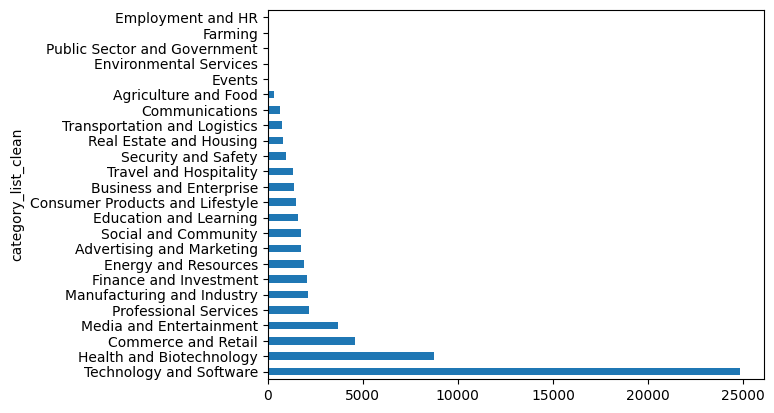

In [80]:
df['category_list_clean'].value_counts(dropna=False).plot(kind='barh')

This code encodes startup categories into machine-readable format:

- **One-Hot Encoding**: Converts `category_list_clean` into binary columns for each industry
- **Configuration**: Uses dense arrays and handles unknown categories gracefully
- **Process**: Creates separate binary features for each industry category

**Benefits**:
- Enables ML algorithms to process industry classification data
- Preserves categorical relationships without ordinal assumptions
- Creates interpretable features for industry-based pattern recognition

In [81]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform category_list_clean
encoded_array = ohe.fit_transform(df[['category_list_clean']])

# Get column names
encoded_cols = ohe.get_feature_names_out(['category_list_clean'])

# Create DataFrame for encoded columns
category_encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)


df = pd.concat([df, category_encoded_df], axis=1)

df.head()

,category_list,funding_total_usd,status,country_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,...,category_list_clean_Manufacturing and Industry,category_list_clean_Media and Entertainment,category_list_clean_Professional Services,category_list_clean_Public Sector and Government,category_list_clean_Real Estate and Housing,category_list_clean_Security and Safety,category_list_clean_Social and Community,category_list_clean_Technology and Software,category_list_clean_Transportation and Logistics,category_list_clean_Travel and Hospitality
0,Media,10000000,operating,IND,Mumbai,Mumbai,1,NaN,2015.0,2015,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE - Other,Delaware City,2,2014.0,2014.0,2014,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Apps|Games|Mobile,3406878,operating,NaN,NaN,NaN,1,NaN,2014.0,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Curated Web,2000000,operating,CHN,Beijing,Beijing,1,2007.0,2008.0,2008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Software,-,operating,USA,"Springfield, Illinois",Champaign,1,2010.0,2014.0,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


This line removes rows with missing geographic data:

- **Targeted Cleaning**: Drops rows where all three geographic columns (`region`, `country_code`, `city`) are simultaneously null
- **Logic**: Uses `how='all'` to only remove records completely missing location information
- **Purpose**: Preserves rows with partial geographic data while eliminating completely unlocatable startups


In [82]:
df = df.dropna(subset=['region', 'country_code', 'city'], how='all')


In [83]:
cols = ['first_funding_at', 'last_funding_at', 'founded_at']
for col in cols:
    dt = pd.to_datetime(df[col])                    

    ints = pd.Series(dt.view('int64'), index=df.index)
    df[col] = ints.where(dt.notna(), pd.NA).astype('Int64')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24276\3077999134.py:5: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24276\3077999134.py:5: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24276\3077999134.py:5: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



This code imputes missing temporal and funding data using KNN:

- **Features**: Founding dates, funding dates, and round counts
- **Algorithm**: KNNImputer with 10 neighbors for context-aware imputation
- **Approach**: Uses patterns from similar startups to estimate missing values

**Benefits**:
- More sophisticated than simple imputation methods
- Preserves relationships between temporal features
- Uses startup similarity for more accurate missing value estimation

In [84]:
features = [
    'founded_at',
    'first_funding_at',
    'last_funding_at',
    'funding_rounds'
]
imputer = KNNImputer(n_neighbors=10)

df[features] = imputer.fit_transform(df[features])

This code imputes missing geographic data using country-based mode imputation:

- **Grouped Imputation**: Fills missing `region` and `city` values based on `country_code` groups
- **Logic**: Uses the most frequent region/city within each country to fill nulls
- **Fallback**: Assigns "Unknown" if no mode exists for a country group

**Benefits**:
- Preserves geographic consistency within countries
- Uses logical patterns (common regions per country)
- Maintains data integrity with appropriate fallback values

In [85]:
df['region'] = df.groupby('country_code')['region'] \
    .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "Unknown"))

df['city'] = df.groupby('country_code')['city'] \
    .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "Unknown"))


In [86]:
df['city'].value_counts()

city
San Francisco    3584
New York         3104
London           2074
Palo Alto         760
Austin            757
                 ... 
Prato               1
Hereford            1
Kefar Sava          1
Muenchen            1
Drinagh             1
Name: count, Length: 4962, dtype: int64

In [87]:
df[df['city']=='unkonwn']

,category_list,funding_total_usd,status,country_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,...,category_list_clean_Manufacturing and Industry,category_list_clean_Media and Entertainment,category_list_clean_Professional Services,category_list_clean_Public Sector and Government,category_list_clean_Real Estate and Housing,category_list_clean_Security and Safety,category_list_clean_Social and Community,category_list_clean_Technology and Software,category_list_clean_Transportation and Logistics,category_list_clean_Travel and Hospitality


as we can see there are no NAN values left

In [88]:
df.isna().sum() 

category_list                                          0
funding_total_usd                                      0
status                                                 0
country_code                                           0
region                                                 0
city                                                   0
funding_rounds                                         0
founded_at                                             0
first_funding_at                                       0
last_funding_at                                        0
category_list_clean                                    0
category_list_clean_Advertising and Marketing          0
category_list_clean_Agriculture and Food               0
category_list_clean_Business and Enterprise            0
category_list_clean_Commerce and Retail                0
category_list_clean_Communications                     0
category_list_clean_Consumer Products and Lifestyle    0
category_list_clean_Education a

This line identifies records with placeholder values in funding data:

- **Data Quality Check**: Finds rows where `funding_total_usd` contains '-' placeholder
- **Purpose**: Detects missing funding information masked as string characters
- **Impact**: Reveals records requiring data cleaning or special handling


In [89]:
df[df['funding_total_usd']=='-']

,category_list,funding_total_usd,status,country_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,...,category_list_clean_Manufacturing and Industry,category_list_clean_Media and Entertainment,category_list_clean_Professional Services,category_list_clean_Public Sector and Government,category_list_clean_Real Estate and Housing,category_list_clean_Security and Safety,category_list_clean_Social and Community,category_list_clean_Technology and Software,category_list_clean_Transportation and Logistics,category_list_clean_Travel and Hospitality
4,Software,-,operating,USA,"Springfield, Illinois",Champaign,1.0,2010.0,2014.0,2014.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10,Entertainment|Games|Software,-,operating,USA,NC - Other,Connellys Springs,1.0,2006.8,2013.0,2013.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11,Networking|Real Estate|Web Hosting,-,operating,USA,Orlando,Orlando,1.0,2013.0,2014.0,2014.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12,Health and Wellness,-,operating,USA,Los Angeles,Los Angeles,1.0,1986.0,2010.0,2010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,Beauty,-,operating,IND,Chennai,Chennai,1.0,2008.0,2013.0,2013.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66335,Mobile|SMS,-,closed,GBR,London,London,1.0,2005.0,2007.0,2007.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
66345,Specialty Chemicals,-,operating,USA,SF Bay Area,San Francisco,1.0,2013.0,2015.0,2015.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66346,Mobile|Networking|Web Hosting,-,operating,USA,Ontario - Inland Empire,Redlands,1.0,2010.0,2011.0,2011.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
66347,Android|Apps|Cloud Computing|Cloud Infrastruct...,-,operating,USA,SF Bay Area,Santa Clara,3.0,2011.2,2012.0,2014.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


This code converts funding data from strings to numerical values:

- **Data Cleaning**: Transforms '-' placeholders into proper `NaN` values using `np.nan`
- **Type Conversion**: Converts valid funding amounts from strings to floats
- **Validation**: Checks the count of missing values after conversion

**Purpose**:
- Replaces invalid placeholder characters with machine-readable nulls
- Enables mathematical operations and statistical analysis on funding data
- Quantifies data completeness after cleaning process

In [90]:
def str_to_float(row):
    if '-' in row:
        row = np.nan
    else:
        row = float(row)
    return row
        
df['funding_total_usd'] = df['funding_total_usd'].apply(str_to_float)

df['funding_total_usd'].isnull().sum()

np.int64(9340)

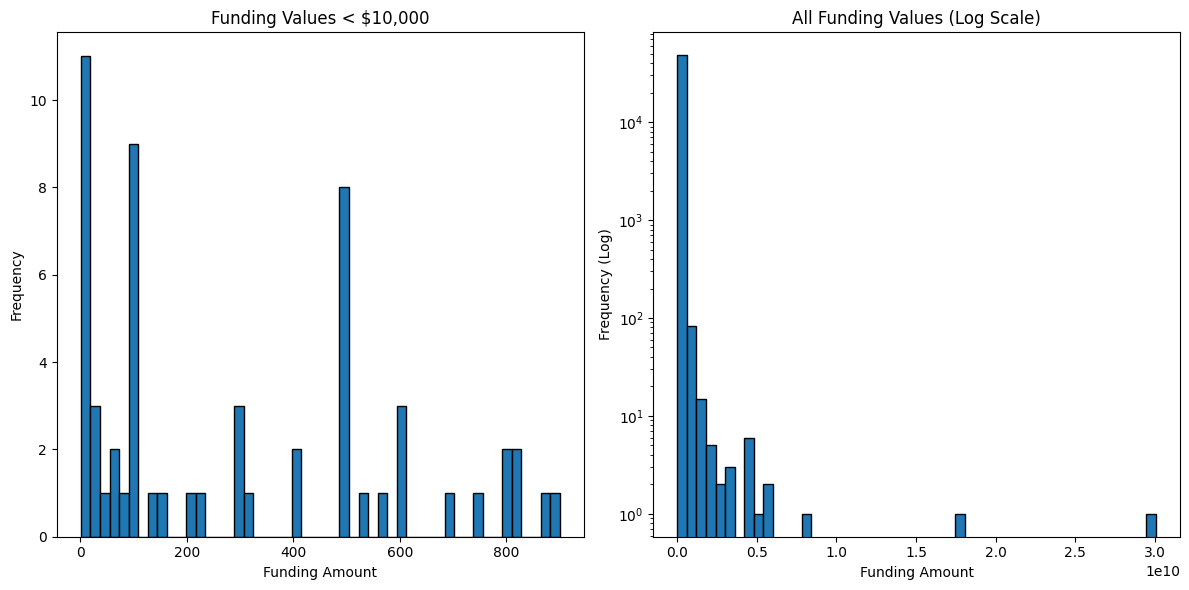

In [91]:
# Plot distribution of all funding values
plt.figure(figsize=(12, 6))

# Histogram for small values
plt.subplot(1, 2, 1)
small_vals = df[df['funding_total_usd'] < 1000]['funding_total_usd']
plt.hist(small_vals, bins=50, edgecolor='black')
plt.title('Funding Values < $10,000')
plt.xlabel('Funding Amount')
plt.ylabel('Frequency')

# Histogram for all values (log scale)
plt.subplot(1, 2, 2)
plt.hist(df['funding_total_usd'], bins=50, edgecolor='black')
plt.yscale('log')
plt.title('All Funding Values (Log Scale)')
plt.xlabel('Funding Amount')
plt.ylabel('Frequency (Log)')

plt.tight_layout()
plt.show()

This code performs grouped imputation for missing funding values:

- **Statistical Analysis**: First calculates funding metrics (mean, median, std) by funding rounds and categories
- **Smart Imputation**: Fills missing `funding_total_usd` values using category-specific and round-specific averages
- **Method**: Uses `.transform()` to apply group-wise mean imputation while preserving DataFrame structure

**Benefits**:
- Context-aware imputation based on similar startups
- Maintains funding patterns within industry segments
- Preserves statistical relationships in the data
- More accurate than global mean imputation

In [92]:
nan_groups = df.groupby(['funding_rounds', 'category_list_clean'])['funding_total_usd'].apply(
    lambda x: x.isna().all()
)
nan_groups = nan_groups[nan_groups == True]

print(f"Groups with all NaN values: {len(nan_groups)}")
print(nan_groups.head())

Groups with all NaN values: 1
funding_rounds  category_list_clean   
10.0            Travel and Hospitality    True
Name: funding_total_usd, dtype: bool


This code handles funding data gaps with strategic imputation:

- **Analysis**: First identifies groups with complete funding data absence
- **Filtering**: Removes startup categories with no funding reference data
- **Imputation**: Fills remaining missing values using group-specific means

**Strategy**:
- Eliminates unreliable segments lacking any funding benchmarks
- Uses peer-based imputation for partial gaps within viable categories
- Ensures funding estimates are grounded in actual category patterns

In [93]:
funding_rounds_group = df.groupby(['funding_rounds','category_list_clean'])['funding_total_usd'].aggregate(['mean','median','std'])

# Drop rows from groups where mean is NaN
nan_groups = funding_rounds_group[funding_rounds_group['mean'].isna()].index
df = df[~df.set_index(['funding_rounds', 'category_list_clean']).index.isin(nan_groups)]

df['fund_value'] = df.groupby(['funding_rounds', 'category_list_clean'])['funding_total_usd'].transform(lambda x: x.fillna(x.mean()))

This code handles outliers in funding data:

- **Outlier Detection**: Uses IQR method on log-transformed funding values
- **Treatment**: Caps extreme values at 1.5×IQR from quartiles
- **Approach**: Applies winsorization to reduce outlier impact

**Benefits**:
- Preserves data points while limiting extreme value influence
- Maintains data distribution shape after log transformation
- Improves model robustness against funding anomalies

In [94]:
# Outlier treatment after log transform
df_clean = df.copy()
df_clean['fund_value'] = np.log1p(df_clean['fund_value'])

Q1, Q3 = df_clean['fund_value'].quantile([0.25, 0.75])
lower, upper = Q1 - 1.5*(Q3-Q1), Q3 + 1.5*(Q3-Q1)

df_clean['fund_value_log_capped'] = np.clip(df_clean['fund_value'], lower, upper)

df=df_clean.copy()

This line removes redundant columns after feature engineering:

- **Columns Dropped**:
  - `category_list`: Original raw categories (replaced by cleaned version)
  - `funding_total_usd`: Original funding column (replaced by imputed `fund_value`)


In [95]:
df = df.drop(columns=['category_list','funding_total_usd'])
df

,status,country_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,category_list_clean,category_list_clean_Advertising and Marketing,...,category_list_clean_Professional Services,category_list_clean_Public Sector and Government,category_list_clean_Real Estate and Housing,category_list_clean_Security and Safety,category_list_clean_Social and Community,category_list_clean_Technology and Software,category_list_clean_Transportation and Logistics,category_list_clean_Travel and Hospitality,fund_value,fund_value_log_capped
0,operating,IND,Mumbai,Mumbai,1.0,2011.8,2015.0,2015.0,Media and Entertainment,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.118096,16.118096
1,operating,USA,DE - Other,Delaware City,2.0,2014.0,2014.0,2014.0,Media and Entertainment,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.458837,13.458837
3,operating,CHN,Beijing,Beijing,1.0,2007.0,2008.0,2008.0,Technology and Software,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,14.508658,14.508658
4,operating,USA,"Springfield, Illinois",Champaign,1.0,2010.0,2014.0,2014.0,Technology and Software,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15.593487,15.593487
5,operating,HKG,Hong Kong,Hong Kong,1.0,2013.0,2014.0,2014.0,Media and Entertainment,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.627431,10.627431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66361,operating,AUT,Vienna,Gerasdorf Bei Wien,1.0,2007.0,2013.0,2013.0,Health and Biotechnology,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.803787,14.803787
66362,operating,GBR,London,London,3.0,2014.0,2014.0,2015.0,Education and Learning,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.928840,13.928840
66363,operating,CHN,Beijing,Beijing,1.0,2010.3,2012.0,2012.0,Technology and Software,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,14.277546,14.277546
66364,operating,HRV,Split,Split,4.0,2012.0,2011.0,2014.0,Technology and Software,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.646626,11.646626


In [96]:
df.isna().sum()

status                                                 0
country_code                                           0
region                                                 0
city                                                   0
funding_rounds                                         0
founded_at                                             0
first_funding_at                                       0
last_funding_at                                        0
category_list_clean                                    0
category_list_clean_Advertising and Marketing          0
category_list_clean_Agriculture and Food               0
category_list_clean_Business and Enterprise            0
category_list_clean_Commerce and Retail                0
category_list_clean_Communications                     0
category_list_clean_Consumer Products and Lifestyle    0
category_list_clean_Education and Learning             0
category_list_clean_Employment and HR                  0
category_list_clean_Energy and 

<Axes: ylabel='status'>

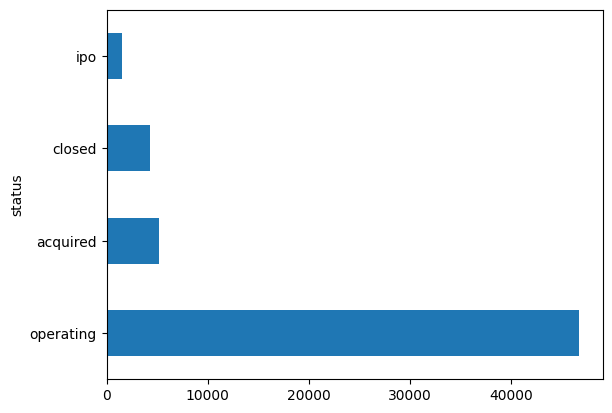

In [97]:
df['status'].value_counts().plot(kind='barh')

This code converts categorical startup status into machine-readable format:

- **One-Hot Encoding**: Transforms `status` column into multiple binary columns
- **Configuration**: `sparse_output=False` for dense arrays, `handle_unknown='ignore'` for robustness
- **Process**: Creates separate columns for each status type (acquired, closed, operating, ipo)
- **Column Removal**: Drops `status_ipo` using `inplace=True` to modify DataFrame directly
- **Purpose**: Reduces multicollinearity in status features

**Benefits**:
- Enables ML algorithms to process categorical status data
- Preserves index alignment for data integrity
- Creates interpretable binary features for modeling

In [98]:
df_sklearn = df.copy()
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df_sklearn[['status']])
new_column_names = encoder.get_feature_names_out(['status'])
encoded_df = pd.DataFrame(
    encoded_data,
    columns=new_column_names,
    index=df_sklearn.index  # Important to keep the correct index
)
df_sklearn_final = pd.concat(
    [df_sklearn.drop(['status'], axis=1), encoded_df],
    axis=1
)

df_sklearn_final.drop(columns=['status_ipo'],inplace=True)
df=df_sklearn_final.copy()
df

,country_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,category_list_clean,category_list_clean_Advertising and Marketing,category_list_clean_Agriculture and Food,...,category_list_clean_Security and Safety,category_list_clean_Social and Community,category_list_clean_Technology and Software,category_list_clean_Transportation and Logistics,category_list_clean_Travel and Hospitality,fund_value,fund_value_log_capped,status_acquired,status_closed,status_operating
0,IND,Mumbai,Mumbai,1.0,2011.8,2015.0,2015.0,Media and Entertainment,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,16.118096,16.118096,0.0,0.0,1.0
1,USA,DE - Other,Delaware City,2.0,2014.0,2014.0,2014.0,Media and Entertainment,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.458837,13.458837,0.0,0.0,1.0
3,CHN,Beijing,Beijing,1.0,2007.0,2008.0,2008.0,Technology and Software,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,14.508658,14.508658,0.0,0.0,1.0
4,USA,"Springfield, Illinois",Champaign,1.0,2010.0,2014.0,2014.0,Technology and Software,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,15.593487,15.593487,0.0,0.0,1.0
5,HKG,Hong Kong,Hong Kong,1.0,2013.0,2014.0,2014.0,Media and Entertainment,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.627431,10.627431,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66361,AUT,Vienna,Gerasdorf Bei Wien,1.0,2007.0,2013.0,2013.0,Health and Biotechnology,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,14.803787,14.803787,0.0,0.0,1.0
66362,GBR,London,London,3.0,2014.0,2014.0,2015.0,Education and Learning,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.928840,13.928840,0.0,0.0,1.0
66363,CHN,Beijing,Beijing,1.0,2010.3,2012.0,2012.0,Technology and Software,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,14.277546,14.277546,0.0,0.0,1.0
66364,HRV,Split,Split,4.0,2012.0,2011.0,2014.0,Technology and Software,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,11.646626,11.646626,0.0,0.0,1.0


This code engineers city-based features for startup ecosystem analysis:

- **City Classification**: Groups cities into tiers based on startup density
- **Tier System**: Mega Hub (2000+), Major Hub (200+), Medium City (20+), Small City
- **Feature Engineering**: Creates meaningful city groups instead of raw city names

**Benefits**:
- Captures startup ecosystem maturity without overfitting to specific cities
- Reduces dimensionality from hundreds of cities to 4 meaningful categories
- Enables analysis of startup success by ecosystem size and maturity

In [99]:
city_counts = df['city'].value_counts()

df['city_clean'] = df['city'].astype(str).str.strip().str.title()

df['city_freq'] = df['city_clean'].map(city_counts)

top_hubs = city_counts.head(20).index.str.title().tolist()

df['is_major_hub'] = df['city_clean'].isin(top_hubs).astype(int)

def group_by_startups(count):
    if count >= 2000:
        return 'Mega Hub'
    elif count >= 200:
        return 'Major Hub'
    elif count >= 20:
        return 'Medium City'
    else:
        return 'Small City'

df['city_group'] = df['city_freq'].apply(group_by_startups)

df.drop(columns=["is_major_hub","city_freq","city_clean","region","city"], inplace=True)
df

,country_code,funding_rounds,founded_at,first_funding_at,last_funding_at,category_list_clean,category_list_clean_Advertising and Marketing,category_list_clean_Agriculture and Food,category_list_clean_Business and Enterprise,category_list_clean_Commerce and Retail,...,category_list_clean_Social and Community,category_list_clean_Technology and Software,category_list_clean_Transportation and Logistics,category_list_clean_Travel and Hospitality,fund_value,fund_value_log_capped,status_acquired,status_closed,status_operating,city_group
0,IND,1.0,2011.8,2015.0,2015.0,Media and Entertainment,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,16.118096,16.118096,0.0,0.0,1.0,Major Hub
1,USA,2.0,2014.0,2014.0,2014.0,Media and Entertainment,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,13.458837,13.458837,0.0,0.0,1.0,Small City
3,CHN,1.0,2007.0,2008.0,2008.0,Technology and Software,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,14.508658,14.508658,0.0,0.0,1.0,Major Hub
4,USA,1.0,2010.0,2014.0,2014.0,Technology and Software,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,15.593487,15.593487,0.0,0.0,1.0,Medium City
5,HKG,1.0,2013.0,2014.0,2014.0,Media and Entertainment,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.627431,10.627431,0.0,0.0,1.0,Medium City
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66361,AUT,1.0,2007.0,2013.0,2013.0,Health and Biotechnology,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14.803787,14.803787,0.0,0.0,1.0,Small City
66362,GBR,3.0,2014.0,2014.0,2015.0,Education and Learning,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,13.928840,13.928840,0.0,0.0,1.0,Mega Hub
66363,CHN,1.0,2010.3,2012.0,2012.0,Technology and Software,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,14.277546,14.277546,0.0,0.0,1.0,Major Hub
66364,HRV,4.0,2012.0,2011.0,2014.0,Technology and Software,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,11.646626,11.646626,0.0,0.0,1.0,Small City


This code encodes startup categories into machine-readable format:

- **One-Hot Encoding**: Converts `category_list_clean` into binary columns for each industry
- **Configuration**: Uses dense arrays and handles unknown categories gracefully
- **Process**: Creates separate binary features for each industry category

**Benefits**:
- Enables ML algorithms to process industry classification data
- Preserves categorical relationships without ordinal assumptions
- Creates interpretable features for industry-based pattern recognition

In [100]:
city_mapping = {
    'Small City': 0,
    'Medium City': 1,
    'Major Hub': 2,
    'Mega Hub': 3
}

# Apply the mapping
df['city_group_encoded'] = df['city_group'].map(city_mapping)

In [41]:
labels = df['city_group'].unique().tolist()
values = df['city_group'].value_counts().tolist()

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.show()

This code creates a bar chart visualizing startup distribution by country:

- **Data Preparation**: Gets top 10 countries by startup count and formats for plotting
- **Visualization**: Uses Plotly Express bar chart with color-coded frequency
- **Customization**: Sets axis labels, chart height, and title for clarity

**Purpose**:
- Reveals geographic concentration of startups
- Highlights dominant countries in the dataset
- Provides quick insight into global startup distribution patterns

In [42]:
country_counts = df['country_code'].value_counts().head(10).reset_index()
country_counts.columns = ['country_code', 'frequency']

fig = px.bar(country_counts, x='country_code', y='frequency',
             color='frequency',
             labels={'frequency':'count', 'country_code':'Country code'},
             height=450)
fig.update_layout(title='Country code frequency (row counts)')
fig.show()

This code visualizes startup distribution excluding dominant countries:

- **Filtered Analysis**: Removes USA and GBR to focus on other countries
- **Purpose**: Reveals secondary startup hubs beyond the top two nations
- **Visualization**: Creates bar chart showing country distribution without outliers


In [43]:
country_counts = df[(df['country_code']!='USA')&(df['country_code']!='GBR')]['country_code'].value_counts().reset_index()
country_counts.columns = ['country_code', 'frequency']

fig = px.bar(country_counts, x='country_code', y='frequency',
             color='frequency',
             labels={'frequency':'count', 'country_code':'Country code'},
             height=450)
fig.update_layout(title='Country code frequency (row counts)')
fig.show()

This code consolidates and encodes country data for machine learning:

- **Country Grouping**: Combines rare countries (<100 startups) into "Other" category
- **One-Hot Encoding**: Converts country groups into binary columns for ML processing
- **Data Cleaning**: Removes original country columns after encoding

**Benefits**:
- Reduces categorical cardinality while preserving key geographic signals
- Maintains important country patterns without overfitting to rare categories
- Creates ML-ready features from geographic data

In [44]:
country_counts = df['country_code'].value_counts()
common_countries = country_counts[country_counts >= 100].index.tolist()

df['country_group'] = df['country_code'].apply(
    lambda x: x if x in common_countries else 'Other'
)

ohe = OneHotEncoder(sparse_output=False, drop=None, handle_unknown='ignore')

# Fit and transform country_group
encoded_array = ohe.fit_transform(df[['country_group']])

# Get column names
encoded_cols = ohe.get_feature_names_out(['country_group'])

# Create DataFrame for encoded columns
country_encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)


df = df.drop(columns=['country_code', 'country_group'])
df = pd.concat([df, country_encoded_df], axis=1)

df.head()

,funding_rounds,founded_at,first_funding_at,last_funding_at,category_list_clean,category_list_clean_Advertising and Marketing,category_list_clean_Agriculture and Food,category_list_clean_Business and Enterprise,category_list_clean_Commerce and Retail,category_list_clean_Communications,...,country_group_NLD,country_group_NOR,country_group_Other,country_group_POL,country_group_PRT,country_group_RUS,country_group_SGP,country_group_SWE,country_group_TUR,country_group_USA
0,1.0,2011.8,2015.0,2015.0,Media and Entertainment,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,2014.0,2014.0,2014.0,Media and Entertainment,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,2007.0,2008.0,2008.0,Technology and Software,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,2010.0,2014.0,2014.0,Technology and Software,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1.0,2013.0,2014.0,2014.0,Media and Entertainment,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
fig = px.box(df, x='funding_rounds', y='fund_value_log_capped', log_y=True, 
             title='Fund Value by Number of Funding Rounds')
fig.show()


In [46]:
fig = px.box(df, x='city_group_encoded', y='fund_value_log_capped', log_y=True,
             title='Fund Value by City Group')
fig.show()


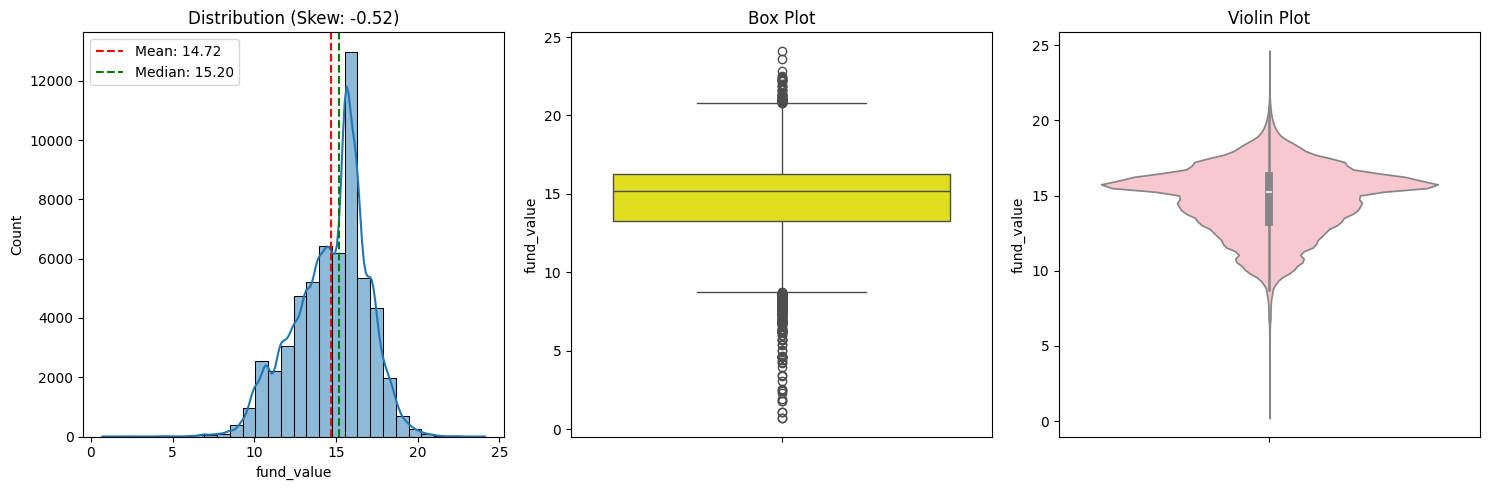

In [103]:
plt.figure(figsize=(15, 5))

# Histogram with KDE
plt.subplot(1, 3, 1)
sns.histplot(df['fund_value'], kde=True, bins=30)
plt.axvline(df['fund_value'].mean(), color='red', linestyle='--', label=f'Mean: {df["fund_value"].mean():.2f}')
plt.axvline(df['fund_value'].median(), color='green', linestyle='--', label=f'Median: {df["fund_value"].median():.2f}')
plt.title(f'Distribution (Skew: {df["fund_value"].skew():.2f})')
plt.legend()

# Box plot
plt.subplot(1, 3, 2)
sns.boxplot(y=df['fund_value'],color='yellow')
plt.title('Box Plot')

# Violin plot
plt.subplot(1, 3, 3)
sns.violinplot(y=df['fund_value'],color='pink')
plt.title('Violin Plot')

plt.tight_layout()
plt.show()

This code creates temporal features for startup lifecycle analysis:

- **Time-Based Features**:
  - `company_age`: Years since founding
  - `years_since_last_time_funding`: Time since most recent funding
  - `years_since_first_time_funding`: Time since initial funding

- **Data Cleaning**: Removes outliers with company age > 50 years

**Purpose**:
- Captures startup maturity and funding recency
- Enables analysis of funding patterns over time
- Filters out anomalous records for better model performance

In [48]:
current_year = 2025
# Age of the company
df['company_age'] = current_year - df['founded_at']
df['years_since_last_time_funding'] = current_year - df['last_funding_at']
df['years_since_first_time_funding'] = current_year - df['first_funding_at']
df.drop(df[df['company_age'] > 50].index, inplace=True)
df=df.drop(columns=['founded_at','first_funding_at','last_funding_at'])

This code prepares features for machine learning:

- **Log Transformation**: Applies log(1+x) to funding data to handle skewness
- **Standardization**: Z-score normalization for funding values (mean=0, std=1)
- **Normalization**: Min-max scaling for temporal features (range 0-1)

**Benefits**:
- Normalizes feature scales for improved model performance
- Handles right-skewed funding distributions
- Creates ML-ready features with consistent scaling

In [50]:
# Copy  dataframe
df_scaled = df.copy()

df_scaled['fund_value_log'] = np.log1p(df_scaled['fund_value'])  


cols_standardize = ['fund_value_log']

scaler_std = StandardScaler()
df_scaled[cols_standardize] = scaler_std.fit_transform(df_scaled[cols_standardize])


cols_normalize = ['years_since_last_time_funding', 'years_since_first_time_funding', 'company_age']

scaler_minmax = MinMaxScaler()
df_scaled[cols_normalize] = scaler_minmax.fit_transform(df_scaled[cols_normalize])

df_scaled = df_scaled.drop(columns=['fund_value'])
df=df_scaled

Funding Intensity

This code creates a funding intensity feature:

- **Metric**: Calculates funding rounds per year of company existence
- **Handling Edge Cases**: Uses `np.where()` to avoid division by zero for new companies
- **Purpose**: Measures how actively a startup raises funding relative to its age

**Insight**:
- High intensity = frequent fundraising, potentially rapid growth
- Low intensity = conservative funding strategy or established company
- Provides normalized measure of funding activity across different company ages

In [51]:
df['funding_intensity'] = df['funding_rounds'] / np.where(df['company_age'] == 0, 1.0, df['company_age'])

Time Gap Between Fundings

This code calculates the funding timeline span:

- **Feature**: `time_gap_funding` represents the time between first and last funding rounds
- **Calculation**: Subtracts years since last funding from years since first funding
- **Purpose**: Captures the duration of a startup's fundraising activity

**Interpretation**:
- Large gap = long fundraising history, established company
- Small gap = recent or concentrated funding activity
- Measures fundraising strategy and company development stage

In [52]:
df['time_gap_funding'] = df['years_since_first_time_funding'] - df['years_since_last_time_funding']

avarage fund log per round

This code creates a normalized funding metric:

- **Feature**: `avg_fund_log_per_round` calculates average log funding per round
- **Purpose**: Measures typical funding amount per round, normalized by round count
- **Benefit**: Provides comparable funding efficiency across companies with different round counts

**Insight**:
- High value = large average rounds (well-funded startups)
- Low value = smaller, more frequent rounds
- Enables fair comparison of funding success across different fundraising strategies

In [53]:
df['avg_fund_log_per_round'] = df['fund_value_log'] / df['funding_rounds']

In [54]:
df.drop(columns=['category_list_clean','city_group'], inplace=True)

This code performs feature selection using Mutual Information:

- **Target Variable**: Uses `status_acquired` for binary classification
- **Method**: Calculates MI scores to measure feature-target relationships
- **Visualization**: Plots top 20 most informative features

**Purpose**:
- Identifies features most predictive of acquisition outcomes
- Helps select relevant variables for acquisition prediction models
- Provides insight into factors correlated with startup success

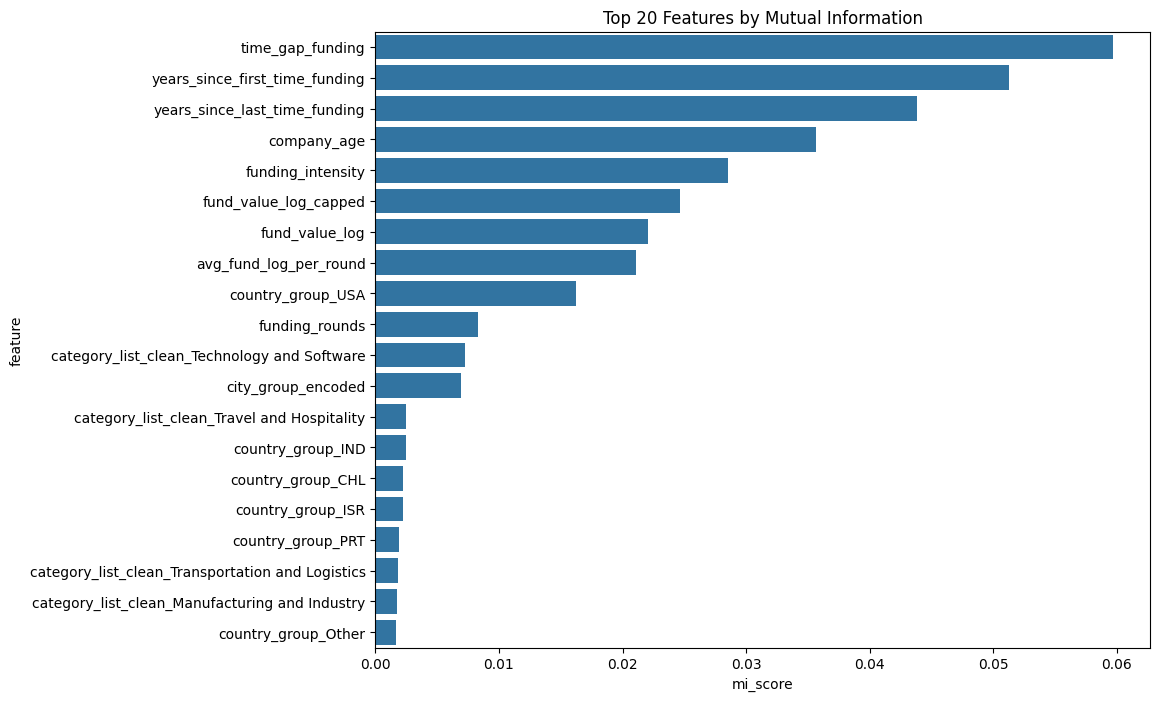

In [55]:
# Prepare features and target (example using status_acquired as target)
X = df.drop(columns=['status_acquired', 'status_closed', 'status_operating'])  # Adjust based on your target
y = df['status_acquired']  # Binary classification: acquired vs not

# Calculate MI scores
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({'feature': X.columns, 'mi_score': mi_scores})
mi_df = mi_df.sort_values('mi_score', ascending=False)

# Plot top features
plt.figure(figsize=(10, 8))
sns.barplot(data=mi_df.head(20), y='feature', x='mi_score')
plt.title('Top 20 Features by Mutual Information')
plt.show()

This code performs Principal Component Analysis on startup numerical features:

- **Features Analyzed**: Funding rounds, company age, funding value, and funding intensity
- **Process**: Standardizes data, applies PCA with 2 components, visualizes results
- **Visualization**: Correlation heatmap, PCA projection, and scree plot

**Purpose**:
- Identifies patterns and relationships in startup funding metrics
- Reduces dimensionality while preserving key information
- Reveals underlying structure in startup financial characteristics
- Assesses how much variance is captured by principal components

=== PCA ANALYSIS OF STARTUP DATA ===
Analyzing 57286 startups with 4 features:
  1. funding_rounds
  2. company_age
  3. fund_value_log
  4. funding_intensity


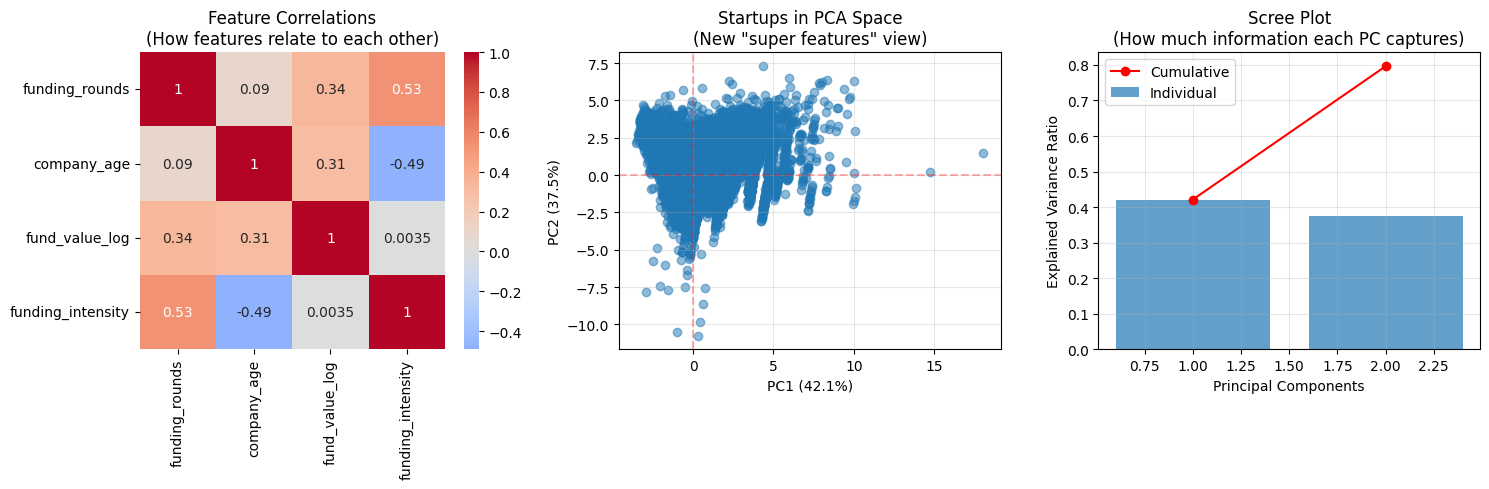


📊 PCA RESULTS EXPLANATION

🔗 1. FEATURE CORRELATIONS ANALYSIS:
   (Values close to +1/-1 mean strong relationship)
   • funding_rounds vs company_age: 0.09 (WEAKLY positively correlated)
   • funding_rounds vs fund_value_log: 0.34 (MODERATELY positively correlated)
   • funding_rounds vs funding_intensity: 0.53 (MODERATELY positively correlated)
   • company_age vs fund_value_log: 0.31 (MODERATELY positively correlated)
   • company_age vs funding_intensity: -0.49 (MODERATELY negatively correlated)
   • fund_value_log vs funding_intensity: 0.00 (WEAKLY positively correlated)

🎯 2. PRINCIPAL COMPONENTS INTERPRETATION:
   PC1 explains 42.1% of variance
   PC2 explains 37.5% of variance
   Total captured by 2 components: 79.6%

   📈 PC1 (Main Pattern) = 
        + 0.56 × funding_rounds
        - 0.40 × company_age
        + 0.10 × fund_value_log
        + 0.72 × funding_intensity

   📊 PC2 (Secondary Pattern) = 
        + 0.44 × funding_rounds
        + 0.59 × company_age
        + 0.66 

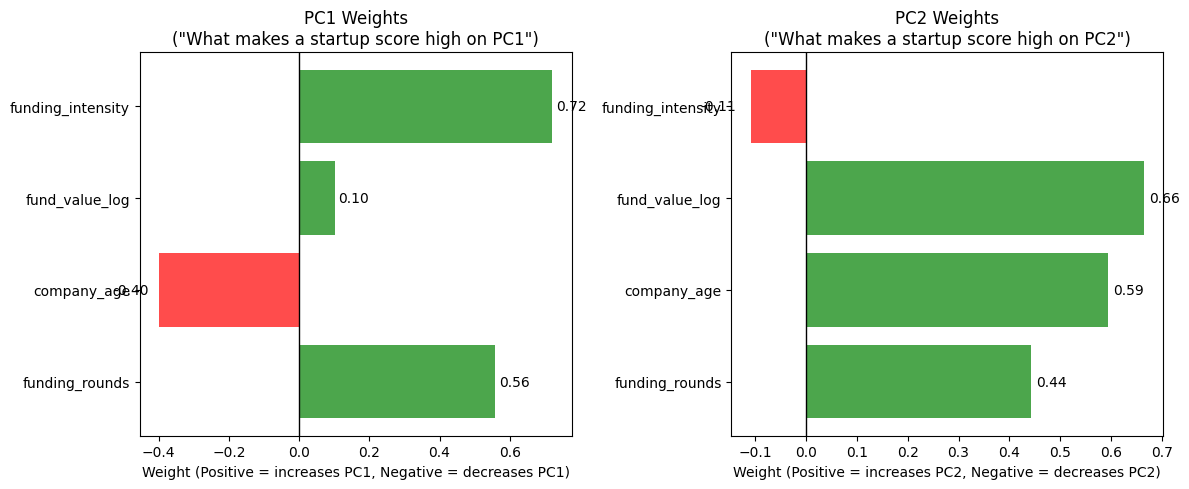


✅ ANALYSIS COMPLETE! You now have 2 powerful 'super features' for your startup analysis.
   Use PC1 and PC2 instead of the original 4 features for modeling and visualization!


In [59]:
# Select numerical features for PCA
numerical_features = ['funding_rounds', 'company_age', 'fund_value_log', 'funding_intensity']
X_numerical = df[numerical_features].dropna()

print("=== PCA ANALYSIS OF STARTUP DATA ===")
print(f"Analyzing {len(X_numerical)} startups with {len(numerical_features)} features:")
for i, feature in enumerate(numerical_features, 1):
    print(f"  {i}. {feature}")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize results
plt.figure(figsize=(15, 5))

# Original features correlation
plt.subplot(1, 3, 1)
correlation_matrix = pd.DataFrame(X_scaled, columns=numerical_features).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations\n(How features relate to each other)')

# PCA results
plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('Startups in PCA Space\n(New "super features" view)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)

# Explained variance
plt.subplot(1, 3, 3)
components = range(1, len(pca.explained_variance_ratio_) + 1)
plt.bar(components, pca.explained_variance_ratio_, alpha=0.7, label='Individual')
plt.plot(components, np.cumsum(pca.explained_variance_ratio_), 'ro-', label='Cumulative')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot\n(How much information each PC captures)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== DETAILED EXPLANATION OF RESULTS ==========
print("\n" + "="*60)
print("📊 PCA RESULTS EXPLANATION")
print("="*60)

# 1. Correlation Analysis
print("\n🔗 1. FEATURE CORRELATIONS ANALYSIS:")
print("   (Values close to +1/-1 mean strong relationship)")
for i in range(len(numerical_features)):
    for j in range(i+1, len(numerical_features)):
        corr = correlation_matrix.iloc[i, j]
        strength = "STRONGLY" if abs(corr) > 0.7 else "MODERATELY" if abs(corr) > 0.3 else "WEAKLY"
        direction = "positively" if corr > 0 else "negatively"
        print(f"   • {numerical_features[i]} vs {numerical_features[j]}: {corr:.2f} ({strength} {direction} correlated)")

# 2. Principal Components Interpretation
print(f"\n🎯 2. PRINCIPAL COMPONENTS INTERPRETATION:")
print(f"   PC1 explains {pca.explained_variance_ratio_[0]:.1%} of variance")
print(f"   PC2 explains {pca.explained_variance_ratio_[1]:.1%} of variance")
print(f"   Total captured by 2 components: {np.sum(pca.explained_variance_ratio_):.1%}")

# What each PC represents
pc1_weights = pca.components_[0]
pc2_weights = pca.components_[1]

print(f"\n   📈 PC1 (Main Pattern) = ")
for i, (weight, feature) in enumerate(zip(pc1_weights, numerical_features)):
    sign = "+" if weight >= 0 else "-"
    print(f"        {sign} {abs(weight):.2f} × {feature}")

print(f"\n   📊 PC2 (Secondary Pattern) = ")
for i, (weight, feature) in enumerate(zip(pc2_weights, numerical_features)):
    sign = "+" if weight >= 0 else "-"
    print(f"        {sign} {abs(weight):.2f} × {feature}")

# 3. Business Interpretation
print(f"\n💼 3. BUSINESS INTERPRETATION:")

# Identify what PC1 represents
pc1_dominant_features = []
for i, weight in enumerate(pc1_weights):
    if abs(weight) > 0.5:  # Significant contribution
        pc1_dominant_features.append((numerical_features[i], weight))

if pc1_dominant_features:
    print(f"   🎯 PC1 mainly represents: ", end="")
    features_desc = []
    for feature, weight in pc1_dominant_features:
        direction = "high" if weight > 0 else "low"
        features_desc.append(f"{direction} {feature}")
    print(" & ".join(features_desc))

# Identify what PC2 represents  
pc2_dominant_features = []
for i, weight in enumerate(pc2_weights):
    if abs(weight) > 0.5:  # Significant contribution
        pc2_dominant_features.append((numerical_features[i], weight))

if pc2_dominant_features:
    print(f"   📊 PC2 mainly represents: ", end="")
    features_desc = []
    for feature, weight in pc2_dominant_features:
        direction = "high" if weight > 0 else "low"
        features_desc.append(f"{direction} {feature}")
    print(" & ".join(features_desc))

# 4. What the PCA Plot Shows
print(f"\n📈 4. READING THE PCA PLOT:")
print(f"   → Startups on the RIGHT have HIGH PC1 scores")
print(f"   → Startups on the LEFT have LOW PC1 scores") 
print(f"   → Startups on the TOP have HIGH PC2 scores")
print(f"   → Startups on the BOTTOM have LOW PC2 scores")
print(f"   → Startups CLOSE TOGETHER are SIMILAR in these patterns")

# 5. Practical Implications
print(f"\n🚀 5. PRACTICAL IMPLICATIONS FOR YOUR STARTUP ANALYSIS:")
print(f"   • You can now analyze startups using just 2 'super features' instead of 4")
print(f"   • This removes redundancy and correlation issues")
print(f"   • Makes visualization and clustering much easier")
print(f"   • Can be used for anomaly detection (outliers far from center)")

# 6. Example Interpretation
print(f"\n🔍 6. EXAMPLE STARTUP PROFILES:")
print(f"   🏆 HIGH PC1, HIGH PC2: ", end="")
# Based on component weights
print("Elite performers with strong funding patterns")

print(f"   📉 LOW PC1, LOW PC2: ", end="")  
print("Early-stage or struggling startups")

print(f"   ➡️  HIGH PC1, LOW PC2: ", end="")
print("Mature companies with established funding")

print(f"   ⬅️  LOW PC1, HIGH PC2: ", end="")
print("Unique funding strategy patterns")

# 7. Component Weights Visualization
print(f"\n🔧 7. COMPONENT WEIGHTS BREAKDOWN:")
plt.figure(figsize=(12, 5))

# PC1 weights
plt.subplot(1, 2, 1)
colors1 = ['green' if x > 0 else 'red' for x in pc1_weights]
bars1 = plt.barh(numerical_features, pc1_weights, color=colors1, alpha=0.7)
plt.axvline(0, color='black', linewidth=1)
plt.title(f'PC1 Weights\n("What makes a startup score high on PC1")')
plt.xlabel('Weight (Positive = increases PC1, Negative = decreases PC1)')
for bar, weight in zip(bars1, pc1_weights):
    plt.text(weight + (0.01 if weight >= 0 else -0.03), bar.get_y() + bar.get_height()/2, 
             f'{weight:.2f}', ha='left' if weight >= 0 else 'right', va='center')

# PC2 weights
plt.subplot(1, 2, 2)
colors2 = ['green' if x > 0 else 'red' for x in pc2_weights]
bars2 = plt.barh(numerical_features, pc2_weights, color=colors2, alpha=0.7)
plt.axvline(0, color='black', linewidth=1)
plt.title(f'PC2 Weights\n("What makes a startup score high on PC2")')
plt.xlabel('Weight (Positive = increases PC2, Negative = decreases PC2)')
for bar, weight in zip(bars2, pc2_weights):
    plt.text(weight + (0.01 if weight >= 0 else -0.03), bar.get_y() + bar.get_height()/2, 
             f'{weight:.2f}', ha='left' if weight >= 0 else 'right', va='center')

plt.tight_layout()
plt.show()

print(f"\n✅ ANALYSIS COMPLETE! You now have 2 powerful 'super features' for your startup analysis.")
print(f"   Use PC1 and PC2 instead of the original 4 features for modeling and visualization!")

Of course. Here is a detailed answer to your question in markdown format.

# The Role of Feature Engineering: From Nice-to-Have to Must-Have

Feature engineering is the process of creating new input features or transforming existing ones to improve the performance of machine learning models. Its necessity depends heavily on the data, the model, and the problem context.

---

## ✅ When Feature Engineering is a "Nice-to-Have"

In these scenarios, you can often get good results with minimal feature engineering, as the model is powerful enough to handle the raw data.

### 1. **Using "Deep Learning" on Raw, High-Dimensional Data**
   - **Examples:** Image recognition (using raw pixels), natural language processing (using raw text tokens with transformers), audio processing.
   - **Why:** Deep neural networks (CNNs, Transformers) are exceptionally good at automatically discovering relevant features and hierarchies from massive amounts of raw, unstructured data. Manual feature engineering here can be inefficient and may not add significant value compared to the model's innate feature extraction capability.

### 2. **Working with Simple, Well-Structured Tabular Data**
   - **Examples:** A clean relational database table with numeric and categorical columns that have a clear, direct relationship to the target variable.
   - **Why:** If the signal in the data is strong and the relationships are linear or simple, even models like Gradient Boosting Machines (e.g., XGBoost, LightGBM) can perform very well with minimal feature engineering.

### 3. **Leveraging Tree-Based Ensemble Models**
   - **Examples:** Using Random Forest or Gradient Boosting for a standard classification/regression task.
   - **Why:** These models are robust to monotonic transformations (like scaling) and can handle a mix of feature types. They are less sensitive to the specific representation of the data compared to models like SVMs or linear regression.

---

## 🚨 When Feature Engineering is a "Must-Have"

In these common scenarios, skipping feature engineering will lead to poor model performance, instability, or complete failure.

### 1. **Using Models with Strong Statistical Assumptions**
   - **Examples:** Linear Regression, Logistic Regression, Support Vector Machines (SVMs with linear kernels), and Naive Bayes.
   - **Why:** These models require:
     - **Numerical Features:** Categorical variables must be encoded (e.g., One-Hot Encoding).
     - **Scaled/Normalized Data:** Features on different scales can unfairly penalize or reward certain coefficients. Scaling (e.g., StandardScaler) is crucial.
     - **Linear Relationships:** Creating interaction terms (e.g., `feature_A * feature_B`) or polynomial features can help capture non-linearity.

### 2. **Working with Text Data (for non-Transformer models)**
   - **Examples:** Building a classifier with Naive Bayes or Logistic Regression on text documents.
   - **Why:** Raw text is unstructured. You **must** convert it into a numerical format. This is feature engineering in its purest form:
     - Bag-of-Words (BoW)
     - TF-IDF (Term Frequency-Inverse Document Frequency)
     - These techniques create the features the model actually uses.

### 3. **Dealing with Time-Series Data**
   - **Examples:** Forecasting sales, predicting stock prices, detecting anomalies in server logs.
   - **Why:** The temporal dimension is critical. You must engineer features to capture patterns like:
     - **Lags:** The value from `t-1`, `t-7` (e.g., yesterday, last week).
     - **Rolling Statistics:** Moving averages, rolling standard deviations.
     - **Seasonality:** Hour of the day, day of the week, month.
     - **Time Since Last Event.**

### 4. **Handling Sparse or Complex Categorical Data**
   - **Examples:** A "user ID" or "product SKU" column with thousands of unique categories.
   - **Why:** One-Hot Encoding such a column would create a massive, sparse, and inefficient feature matrix. You **must** use techniques like:
     - **Target Encoding:** Replacing categories with the average value of the target variable for that category.
     - **Embeddings:** Learning a dense, lower-dimensional representation (common in deep learning).

### 5. **When Domain Knowledge Provides Critical Insight**
   - **Examples:** In finance, creating a "debt-to-income ratio" from raw income and debt columns. In e-commerce, creating "purchases per session" from clickstream data.
   - **Why:** A model might struggle to learn these complex, human-intuitive relationships from the base features alone. Providing these engineered features gives the model a direct, powerful signal it can leverage.

### 6. **Addressing Missing or Noisy Data**
   - **Examples:** Sensor data with dropouts, customer surveys with unanswered questions.
   - **Why:** Most models cannot handle missing values natively. You **must** perform imputation (e.g., filling with mean, median, or a placeholder value), which is a fundamental part of feature engineering.

---
